# Load and explore the data set

In [1]:
# Load dataset
import numpy as np

# Load data of patient Z
p_z = np.load('datasets/ps3_patient_zet.npy')

# Load data of other patients 
p_others = np.load('datasets/ps3_genetic_fingerprints.npy')

In [2]:
# data exploration
p_z.shape # p_z = 1 x 512

(512,)

In [3]:
# data exploration
p_others.shape # p_others = 16930 x 512

(16930, 512)

# Find the optimal number of clusters

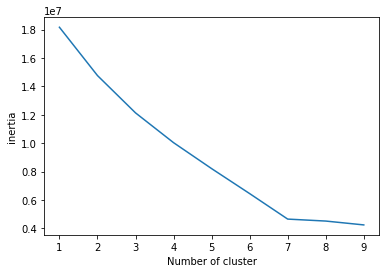

In [27]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Print the inertia plot to find the optimal number of clusters
inertia_score = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k).fit(p_others)
    inertia_score[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(inertia_score.keys()), list(inertia_score.values()))
plt.xlabel("Number of cluster")
plt.ylabel("inertia")

# save figure
plt.savefig('inertia plot')

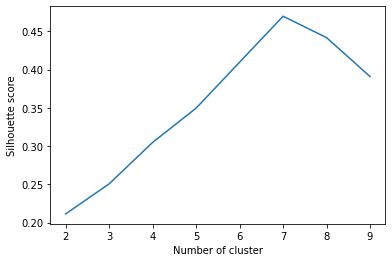

In [28]:
# Lets plot silhouette score plot to prove our results
from sklearn.metrics import silhouette_score
s_score = {}
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k).fit(p_others)
    s_score[k] = silhouette_score(p_others, kmeans.labels_)

plt.figure()
plt.plot(list(s_score.keys()), list(s_score.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette score")

# save figure
plt.savefig('silhouette score plot')

### IMPORTANT FINDING:
From these plots, it is obvious that the optimal number of clusters is 7

# K-means

In [16]:
from sklearn.cluster import KMeans
k = 7
kmeans = KMeans(n_clusters=k).fit(p_others)

# using kmeans to predict which patient belongs to which cluster
y_kmeans = kmeans.predict(p_others)

In [17]:
kmeans.cluster_centers_

array([[ 0.0000000e+00,  1.3460522e-10,  0.0000000e+00, ...,
         0.0000000e+00, -1.9324943e-08, -2.9103830e-09],
       [ 0.0000000e+00,  2.9864986e-04,  0.0000000e+00, ...,
         0.0000000e+00,  5.8226986e-05, -2.7939677e-09],
       [ 0.0000000e+00,  1.3096724e-10,  0.0000000e+00, ...,
         0.0000000e+00,  3.8512563e-04, -3.0267984e-09],
       ...,
       [ 0.0000000e+00,  1.3460522e-10,  0.0000000e+00, ...,
         0.0000000e+00,  2.3254254e-03,  4.4172979e-05],
       [ 0.0000000e+00,  1.3460522e-10,  0.0000000e+00, ...,
         0.0000000e+00, -1.7229468e-08,  7.9457853e-03],
       [ 0.0000000e+00,  1.3460522e-10,  0.0000000e+00, ...,
         0.0000000e+00,  5.9161768e-03, -2.7939677e-09]], dtype=float32)

In [18]:
y_kmeans

array([5, 5, 4, ..., 2, 6, 6], dtype=int32)

In [19]:
# find the cluster to which patient Z belongs 
p_z_cluster = kmeans.predict(p_z.reshape(1,-1))

In [20]:
p_z_cluster

array([2], dtype=int32)

In [21]:
# find the number of patients of each cluster 
from collections import Counter
print(Counter(kmeans.labels_))

Counter({0: 2715, 5: 2496, 2: 2422, 3: 2412, 4: 2384, 6: 2344, 1: 2157})


# PCA

In [22]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(p_others)

# find cumsum of pca explained variance ratio
cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum[:3]

array([0.21908994, 0.40710294, 0.5581414 ], dtype=float32)

In [30]:
d = np.argmax(cumsum >= 0.95) + 1
d

41

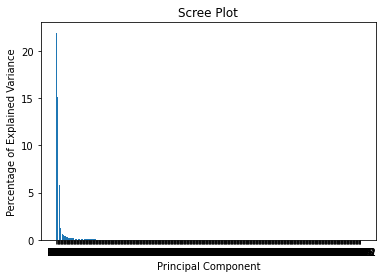

In [33]:
#The following code constructs the Scree plot
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
# save figure
plt.savefig('Scree Plot')

In [23]:
# plot dataset to 2-d
pca_2 = PCA(n_components = 2)

# using pca to transform original data set, cluster centers, and patient z
pca_2_data = pca_2.fit_transform(p_others)
pca_cluster_center = pca_2.fit_transform(kmeans.cluster_centers_)
pca_patient_z = pca_2.transform(p_z.reshape(1,-1))

In [24]:
pca_cluster_center[p_z_cluster] # find the center of cluster to which patient z belongs

array([[ 1.0881922, -3.7909663]], dtype=float32)

In [25]:
pca_cluster_center # find the center of each cluster

array([[ -7.240641 ,  -8.413081 ],
       [ 21.629122 ,  18.780424 ],
       [  1.0881922,  -3.7909663],
       [ -9.895903 ,  19.736593 ],
       [ -7.1289644, -16.994896 ],
       [ 21.355349 , -13.930249 ],
       [-19.807154 ,   4.612189 ]], dtype=float32)

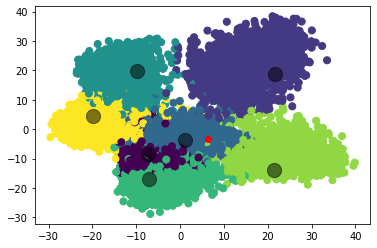

In [26]:
import matplotlib.pyplot as plt

fig = plt.figure()

X = pca_2_data
centers = pca_cluster_center 

p_z_X = pca_patient_z

# plot original data set
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

# plot cluster centers
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

# plot where patient Z belong (red point)
plt.scatter(p_z_X[:, 0], p_z_X[:, 1], c='red')

# save figure
plt.savefig('2-d pca plot')

# Create output csv file

In [20]:
import csv
with open('output.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Id", "Predicted"])
    
    i = 0
    for ele in y_kmeans:
        if ele == p_z_cluster:
            writer.writerow([i, 1])
        else:
            writer.writerow([i, 0])
        i += 1